In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys 
root_dir="/content/drive/MyDrive/M.tech.Thesis/"
sys.path.append(root_dir)

In [ ]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from attention import AttentionLayer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv(root_dir+"Reviews.csv")

In [ ]:
data.shape

(568454, 10)

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [ ]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data.shape

(393565, 10)

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [ ]:
import string
from wordcloud import WordCloud

In [ ]:
data.shape

(393565, 10)

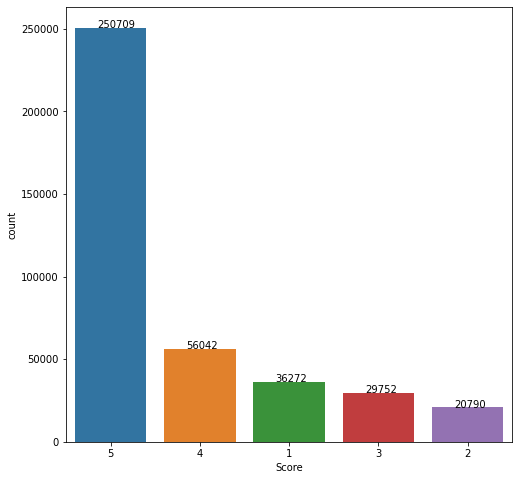

In [ ]:
#Visualizing total count of scores:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
ax = sns.countplot(x=data["Score"],  data=data, order = data["Score"].value_counts().index )
for p, label in zip(ax.patches, data["Score"].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))

In [ ]:
#Group by productId with more than 400 products:

data.groupby('ProductId').count()
data_products = data.groupby('ProductId').filter(lambda x: len(x) >= 400)
df_product_groups = data_products.groupby('ProductId')

#Count of products and groups
print(len(data_products))
print(len(df_product_groups))

12030
23


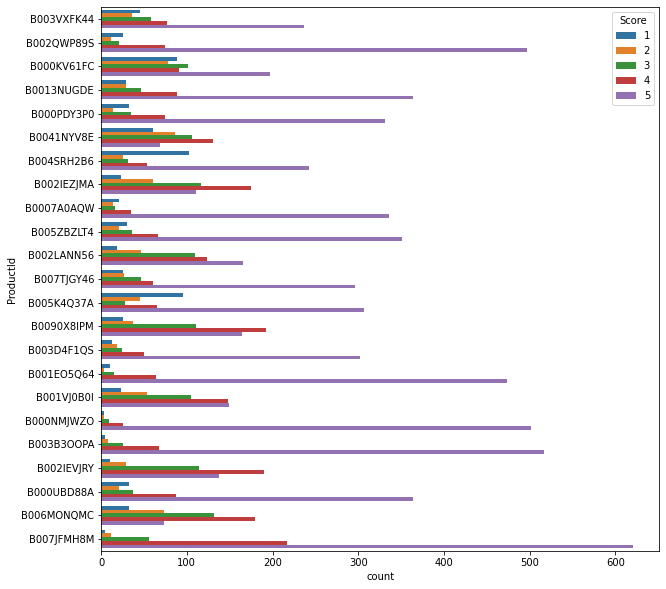

In [ ]:
#Plot the scores product-wise

plt.figure(figsize=(10,10))
sns.countplot(y="ProductId",  hue="Score", data=data_products)

In [ ]:
#Group by UserId who gave more than 100 reviews:
data.groupby('UserId').count()
df_users = data.groupby('UserId').filter(lambda x: len(x) >= 100)
df_userGroup = df_users.groupby('UserId')
print("Number of Users:"+ str(len(df_userGroup)))
df_products = df_users.groupby('ProductId')
print("Number of products:"+ str(len(df_products)))

Number of Users:18
Number of products:2506


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
def remove_Stopwords(text ):
    stop_words = set(stopwords.words('english')) 
    words = word_tokenize( text.lower() ) 
    sentence = [w for w in words if not w in stop_words]
    return " ".join(sentence)
    
def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist) 
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr]) 
    
    return text2.lower()

In [ ]:
mask = (data["Score"] == 1) | (data["Score"] == 2)
df_rating1 = data[mask]
mask = (data["Score"]==4) | (data["Score"]==5) | (data["Score"]==3)
df_rating2 = data[mask]
print(len(df_rating1))
print(len(df_rating2))

57062
336503


In [ ]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [ ]:
df_rating1['Text'] = df_rating1['Text'].apply(clean_text)
df_rating1['Text'] = df_rating1['Text'].apply(remove_Stopwords)
df_rating1['Text'] = df_rating1['Text'].apply(lemmatize_text)
df_rating2['Text'] = df_rating2['Text'].apply(clean_text)
df_rating2['Text'] = df_rating2['Text'].apply(remove_Stopwords)
df_rating2['Text'] = df_rating2['Text'].apply(lemmatize_text)
df_rating1['Num_words_text'] = df_rating1['Text'].apply(lambda x:len(str(x).split())) 
df_rating2['Num_words_text'] = df_rating2['Text'].apply(lambda x:len(str(x).split()))

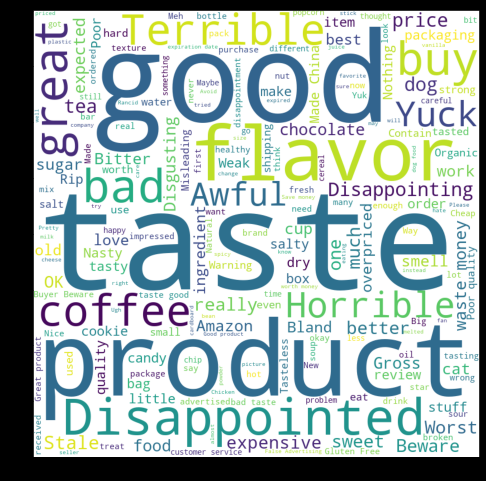

In [ ]:
# negative reviews
wordcloud = WordCloud(background_color="white",width=800, height=800).generate(' '.join(df_rating1['Summary'].tolist()))
plt.figure( figsize=(8,15), facecolor='k')
plt.imshow(wordcloud)

(-0.5, 799.5, 799.5, -0.5)

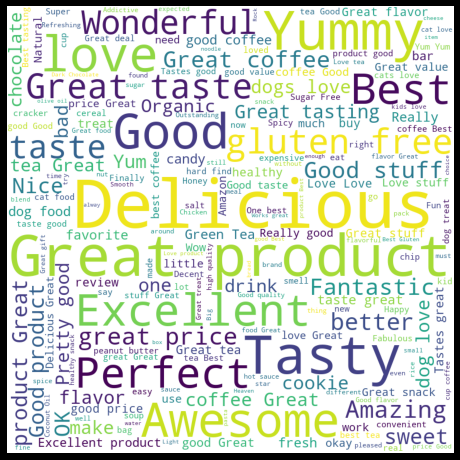

In [ ]:
# positive reviews
wordcloud = WordCloud(background_color="white",width=800, height=800).generate(' '.join(df_rating2['Summary'].tolist()))
plt.figure( figsize=(8,15), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [ ]:
data['scores'] = data['Text'].apply(lambda t: sid.polarity_scores(t))

data['compound']  = data['scores'].apply(lambda score_dict: score_dict['compound'])

data['comp_score'] = data['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,scores,compound,comp_score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,"{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}",0.9441,pos
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".","{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'compound': -0.5664}",-0.5664,neg
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...","{'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'compound': 0.8265}",0.8265,pos
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,pos
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.","{'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.9468}",0.9468,pos


In [ ]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'scores',
       'compound', 'comp_score'],
      dtype='object')

In [ ]:
data_cpy=data.copy()

In [ ]:
data_cpy.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time'],axis=1,inplace=True)

In [ ]:
data_cpy.columns

Index(['Score', 'Summary', 'Text', 'scores', 'compound', 'comp_score'], dtype='object')

In [ ]:
data_cpy.head(10)

,Score,Summary,Text,scores,compound,comp_score
0,5,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,"{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}",0.9441,pos
1,1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".","{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'compound': -0.5664}",-0.5664,neg
2,4,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...","{'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'compound': 0.8265}",0.8265,pos
3,2,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,pos
4,5,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.","{'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.9468}",0.9468,pos
5,4,Nice Taffy,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa...","{'neg': 0.029, 'neu': 0.809, 'pos': 0.163, 'compound': 0.883}",0.8830,pos
6,5,Great! Just as good as the expensive brands!,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ...","{'neg': 0.034, 'neu': 0.693, 'pos': 0.273, 'compound': 0.9346}",0.9346,pos
7,5,"Wonderful, tasty taffy",This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!,"{'neg': 0.0, 'neu': 0.52, 'pos': 0.48, 'compound': 0.9487}",0.9487,pos
8,5,Yay Barley,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too,"{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.6369}",0.6369,pos
9,5,Healthy Dog Food,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.,"{'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.8313}",0.8313,pos
